In [47]:
import requests, re
from bs4 import BeautifulSoup
import pandas as pd
import os
import pprint
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import collections
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from matplotlib.pyplot import figure
from statistics import mean, median
import spacy

# Data collection

This part contains code for scraping Wikipedia biographies of physicists and philosophers.

In [7]:
BASE_URL = "https://en.wikipedia.org"

In [44]:
def get_philo_list_links():
    """Returns a list of links which are list of philosophers by period."""
    url = "https://en.wikipedia.org/wiki/Category:Lists_of_philosophers_by_period"

    # Get base page
    page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.content, 'html.parser')

    # Get all links in the ul
    philo_pages_link = soup.select(".mw-category-group ul li a")

    # Extract the urls
    philo_pages_url = [BASE_URL + link.get('href') for link in philo_pages_link]

    return philo_pages_url


In [45]:
def get_philo_links(list_urls):
    """Return a list of links which are about philosophers."""
    urls = []
    for url in list_urls:
        # Get list page
        page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.content, 'html.parser')

        # Get all links in the ul
        # Exclude a tags with class new to avoid red links
        # Exclude last ul which is see also
        pages_link = soup.select(".mw-parser-output > ul:not(:last-of-type) > li > a:not(.new)")

        # Extract the urls
        pages_url = [BASE_URL + link.get('href') for link in pages_link]
        urls.extend(pages_url)

    return urls

In [46]:
def get_physi_list_links():
    """Returns a list of links which are list of physicists by century."""
    url = "https://en.wikipedia.org/wiki/Category:Physicists_by_century"

    # Get base page
    page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.content, 'html.parser')

    # Get first level (category) links
    pages_link = soup.select(".mw-category-group:last-of-type > ul > li > .CategoryTreeSection > .CategoryTreeItem > a")
    pages_url = [BASE_URL + link.get('href') for link in pages_link]

    # Get second level (individual) links
    physi_list_urls = []
    for page_url in pages_url:
        page = requests.get(url=page_url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.content, 'html.parser')

        pages_link = soup.select(".mw-category-group > ul > li > .CategoryTreeSection > .CategoryTreeItem > a")
        physi_list_urls.extend([BASE_URL + link.get('href') for link in pages_link])

    return physi_list_urls

In [47]:
def get_physi_links(list_urls):
    """Return a list of links which are about physicists."""
    urls = []
    for url in list_urls:
        # Get list page
        page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.content, 'html.parser')

        # Get all links in the ul
        # Exclude a tags with class new to avoid red links
        pages_link = soup.select(".mw-category > .mw-category-group > ul > li > a:not(.new)")

        # Extract the urls
        pages_url = [BASE_URL + link.get('href') for link in pages_link]
        urls.extend(pages_url)

    return urls

In [63]:
def get_page_title_content(url):
    """Return the title and content of a wikipedia page."""
    page = requests.get(url=url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(page.content, 'html.parser')

    # Get the title of the page
    title = soup.select("#firstHeading")[0].text

    # Get the content of the page
    content = soup.select("#mw-content-text > div.mw-parser-output > p")

    # Extract the text
    text = [p.text for p in content]

    # join with space, remove \n and \xa0, remove [digits], remove {style settings}
    text = " ".join(text).replace("\n", "").replace("\xa0", " ").strip()
    text = re.sub(r"\[\d+\]", "", text)
    text = re.sub(r"\{.*\}", "", text)

    return title, text

In [66]:
def write_txt(title, category, text):
    """Write the text to a txt file."""
    # Format the title
    title = title.title().replace(" ", "")
    title = re.sub(r"\(.*\)", "", title)

    # Create the directory if it doesn't exist
    os.makedirs(f"./{category}", exist_ok=True)

    with open(f"./{category}/{title}_{category}.txt", "w", encoding="utf8") as f:
        f.write(text)

In [65]:
def get_texts(list_urls, category):
    """
    Write a txt file for each url.
    Return a set of texts.
    """
    texts = set()
    for url in list_urls:
        # Get title and page content
        title, text = get_page_title_content(url)

        # Add to the set
        texts.add(text)

        # Write a txt file
        write_txt(title, category, text)

    return texts

In [61]:
# Scraping
philo_list_urls = get_philo_list_links()
philo_urls = get_philo_links(philo_list_urls)

physi_list_urls = get_physi_list_links()
physi_urls = get_physi_links(physi_list_urls)

philo_texts = get_texts(philo_urls, "Philosopher")
physi_texts = get_texts(physi_urls, "Physicist")

In [ ]:
# Create a dataframe with text-category pairs
data = [(text, "Philosopher") for text in philo_texts] + \
       [(text, "Physicist") for text in physi_texts]

df = pd.DataFrame(data, columns=["text", "category"])

In [2]:
len(philo_texts), len(physi_texts), len(df)

(3696, 2763, 6459)

# Data Analysis

In [3]:
# loading data
# read in philosopher text files
philo_dir = "./Philosopher"
phys_dir = "./Physicist"

philo_texts = []
for file in os.listdir(philo_dir):
    with open(os.path.join(philo_dir, file), 'r') as f:
        philo_texts.append(f.read())

# read in physicist text files
phys_texts = []
for file in os.listdir(phys_dir):
    with open(os.path.join(phys_dir, file), 'r') as f:
        phys_texts.append(f.read())

# create dataframe with text-category pairs
data = [(text, "Philosopher") for text in philo_texts] + \
       [(text, "Physicist") for text in phys_texts]

df = pd.DataFrame(data, columns=["text", "category"])

In [4]:
df.head()

,text,category
0,Dharmakīrti (fl. c. 6th or 7th century; Tibeta...,Philosopher
1,Christina M. Slade (born 1953) is an Australia...,Philosopher
2,Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ph...,Philosopher
3,Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς; c....,Philosopher
4,Sally Haslanger (/ˈhæslæŋər/) is an American p...,Philosopher


## Text preprocessing

**Since we want to do relevant statistical analysis, we have to preprocess our data by deleting irrelevant for meaning and frequent words (stop words) and lowercase the tokens since the same word in different case is considered as two different words.**

Things to do:
* tokenize the texts
* lowercase all words
* remove punctuation
* remove stop words
* remove all non-aphabetical symbols
* normalize words

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_w = set(stopwords.words('english')) # define the stop words

[nltk_data] Downloading package punkt to /Users/hzh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hzh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hzh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/hzh/nltk_data...


In [8]:
def preprocess(text, remove_stop_words=True):
    
    """ 
    removes non-ASCII chars, performs tokenization, lowercases the tokens,
    delete stopwords, punctuation and non-alphabetical characters,
    converts tokens to normal form
    
    """
    text =  ''.join(filter(lambda x: x in string.printable, text)) # remove non-ASCII chars

    tokens = word_tokenize(text) # tokenization
    tokens = [token.lower() for token in tokens] # lowercase
    tokens = [token for token in tokens if token not in string.punctuation] # remove punctuation
    tokens = [token for token in tokens if token.isalpha()] # remove non-alphabetical characters
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_w] # remove stopwords

    lemmatizer = WordNetLemmatizer()  
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # convert to normal form

    return tokens

In [9]:
df["tokens_without_sw"] = df["text"].apply(lambda x: preprocess(x))
df["tokens_sw"] = df["text"].apply(lambda x: preprocess(x, remove_stop_words=False))
df["sentences"] = df["text"].apply(lambda x: sent_tokenize(x))
df["sentences_tokens"] = df["sentences"].apply(lambda x: [preprocess(sent, remove_stop_words=True) for sent in x])

In [12]:
df.head()

,text,category,tokens_without_sw,tokens_sw,sentences,sentences_tokens
0,Dharmakīrti (fl. c. 6th or 7th century; Tibeta...,Philosopher,"[dharmakrti, fl, century, tibetan, wylie, chos...","[dharmakrti, fl, or, century, tibetan, wylie, ...","[Dharmakīrti (fl., c. 6th or 7th century; Tibe...","[[dharmakrti, fl], [century, tibetan, wylie, c..."
1,Christina M. Slade (born 1953) is an Australia...,Philosopher,"[christina, slade, born, australian, academic,...","[christina, slade, born, is, an, australian, a...",[Christina M. Slade (born 1953) is an Australi...,"[[christina, slade, born, australian, academic..."
2,Tsang Lap Chuen (Chinese: 曾立存) is a Chinese ph...,Philosopher,"[tsang, lap, chuen, chinese, chinese, philosop...","[tsang, lap, chuen, chinese, is, a, chinese, p...",[Tsang Lap Chuen (Chinese: 曾立存) is a Chinese p...,"[[tsang, lap, chuen, chinese, chinese, philoso..."
3,Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς; c....,Philosopher,"[callicles, greek, late, century, bc, thought,...","[callicles, greek, late, century, bc, is, thou...",[Callicles (/ˈkælɪkliːz/; Greek: Καλλικλῆς; c...,"[[callicles, greek, late, century, bc, thought..."
4,Sally Haslanger (/ˈhæslæŋər/) is an American p...,Philosopher,"[sally, haslanger, american, philosopher, prof...","[sally, haslanger, is, an, american, philosoph...",[Sally Haslanger (/ˈhæslæŋər/) is an American ...,"[[sally, haslanger, american, philosopher, pro..."


## Explanatory Data Analysis

### Distribution of texts by category

<Axes: xlabel='category', ylabel='count'>

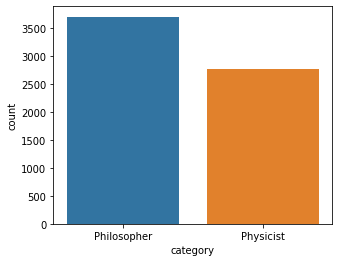

In [13]:
plt.figure(figsize=(5,4))

x= df.category.value_counts()
sns.countplot(x= "category",data=df)

## Vocabulary: statistics and plots

### Get most frequent words per category

In [15]:
# split the initial data into two datasets according to the category 
df_phil = df[df["category"] == "Philosopher"]
df_phys = df[df["category"] == "Physicist"]

In [18]:
tokens_phil_without_sw = []
tokens_phys_without_sw = []
tokens_phil_sw = []
tokens_phys_sw = []

for tokens_list in df_phil["tokens_without_sw"]:  # get all the tokens without sw for Philosopher category
    tokens_phil_without_sw += tokens_list
    
for tokens_list in df_phys["tokens_without_sw"]:  # get all the tokens without sw for Physicist category
    tokens_phys_without_sw += tokens_list
    
for tokens_list in df_phil["tokens_sw"]:  # get all the tokens with sw for Philosopher category
    tokens_phil_sw += tokens_list

for tokens_list in df_phys["tokens_sw"]:  # get all the tokens with swfor Physicist category
    tokens_phys_sw += tokens_list

In [19]:
# Get the 50 most common words for Philosopher
top_words_phil = dict(collections.Counter(tokens_phil_without_sw).most_common(50))

# Get the 50 most common words for Phiycisist
top_words_phys = dict(collections.Counter(tokens_phys_without_sw).most_common(50))

# Get the 50 most common words for Philosopher with stopwords
top_words_phil_sw = dict(collections.Counter(tokens_phil_sw).most_common(50))

# Get the 50 most common words for Phiycisist with stopwords
top_words_phys_sw = dict(collections.Counter(tokens_phys_sw).most_common(50))

### 50 most frequent words per category without stop words

In [22]:
print(f"Top 50 words for Philosopher without stopwords:")
print(list(top_words_phil.keys()))

Top 50 words for Philosopher without stopwords:
['philosophy', 'work', 'university', 'also', 'one', 'book', 'first', 'time', 'year', 'theory', 'life', 'state', 'published', 'new', 'philosopher', 'would', 'science', 'later', 'world', 'professor', 'two', 'school', 'de', 'study', 'became', 'wrote', 'human', 'idea', 'many', 'political', 'society', 'known', 'social', 'view', 'god', 'law', 'writing', 'thought', 'history', 'according', 'philosophical', 'born', 'american', 'john', 'may', 'college', 'death', 'people', 'however', 'part']


In [23]:
print(f"Top 50 words for Phisicist without stopwords:")
print(list(top_words_phys.keys()))

Top 50 words for Phisicist without stopwords:
['university', 'physic', 'research', 'science', 'professor', 'institute', 'also', 'work', 'first', 'theory', 'physicist', 'year', 'became', 'born', 'quantum', 'member', 'one', 'study', 'nuclear', 'society', 'scientific', 'academy', 'state', 'field', 'received', 'national', 'new', 'worked', 'time', 'theoretical', 'prize', 'laboratory', 'later', 'technology', 'published', 'known', 'director', 'physical', 'two', 'school', 'department', 'fellow', 'scientist', 'awarded', 'system', 'energy', 'american', 'german', 'degree', 'paper']


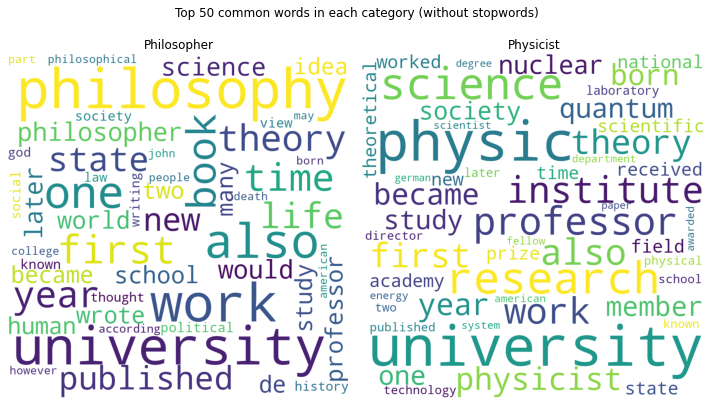

In [25]:
wordcloud_phil = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phil)
wordcloud_phys = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phys)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Top 50 common words in each category (without stopwords)")

ax1.imshow(wordcloud_phil)
ax1.axis("off")
ax1.set_title("Philosopher")

ax2.imshow(wordcloud_phys)
ax2.axis("off")
ax2.set_title("Physicist")

plt.tight_layout()
plt.show()

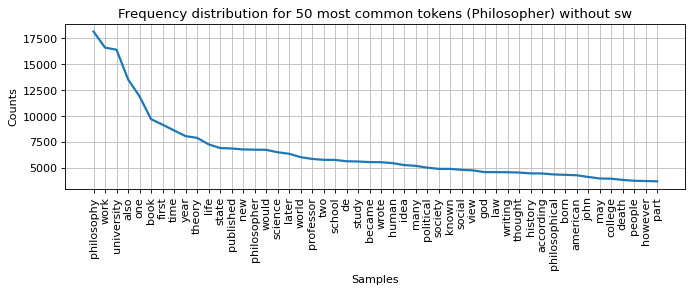

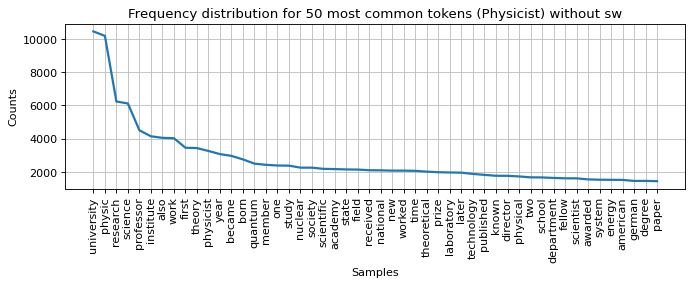

<Figure size 432x288 with 0 Axes>

In [28]:
fdist1 = FreqDist(top_words_phil)
fdist2 = FreqDist(top_words_phys)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens (Philosopher) without sw")
fdist1.plot(50)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens (Physicist) without sw")
fdist2.plot(50)

plt.tight_layout()
plt.show()

### 50 most frequent words per category with stop words

In [29]:
print(f"Top 50 words for Philosopher with stopwords:")
print(list(top_words_phil_sw.keys()))

Top 50 words for Philosopher with stopwords:
['the', 'of', 'and', 'a', 'in', 'to', 'he', 'his', 'wa', 'that', 'is', 'on', 'for', 'by', 'with', 'at', 'it', 'from', 'an', 'which', 'philosophy', 'this', 'not', 'be', 'work', 'university', 'had', 'also', 'or', 'are', 'but', 'one', 'were', 'ha', 'who', 'have', 'book', 'her', 'first', 'him', 'she', 'time', 'their', 'been', 'after', 'year', 'theory', 'other', 'all', 'they']


In [30]:
print(f"Top 50 words for Phisicist with stopwords:")
print(list(top_words_phys_sw.keys()))

Top 50 words for Phisicist with stopwords:
['the', 'of', 'in', 'and', 'a', 'to', 'he', 'wa', 'at', 'his', 'for', 'on', 'university', 'physic', 'with', 'from', 'is', 'that', 'by', 'an', 'research', 'science', 'she', 'professor', 'which', 'it', 'institute', 'also', 'work', 'this', 'first', 'had', 'theory', 'her', 'ha', 'physicist', 'after', 'year', 'were', 'became', 'born', 'where', 'quantum', 'member', 'be', 'one', 'study', 'nuclear', 'society', 'scientific']


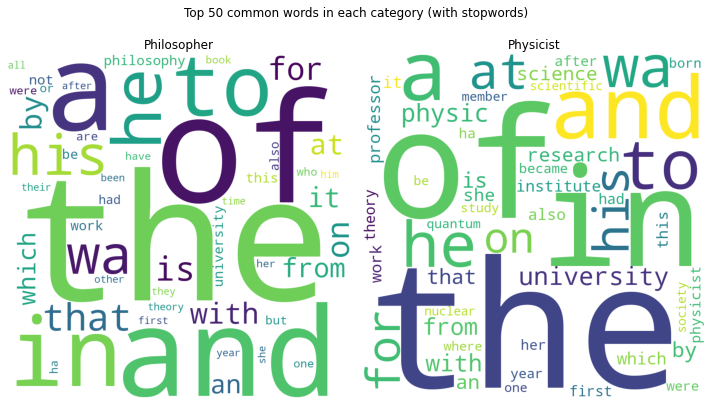

In [31]:
wordcloud_phil = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phil_sw)
wordcloud_phys = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_phys_sw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Top 50 common words in each category (with stopwords)")

ax1.imshow(wordcloud_phil)
ax1.axis("off")
ax1.set_title("Philosopher")

ax2.imshow(wordcloud_phys)
ax2.axis("off")
ax2.set_title("Physicist")

plt.tight_layout()
plt.show()

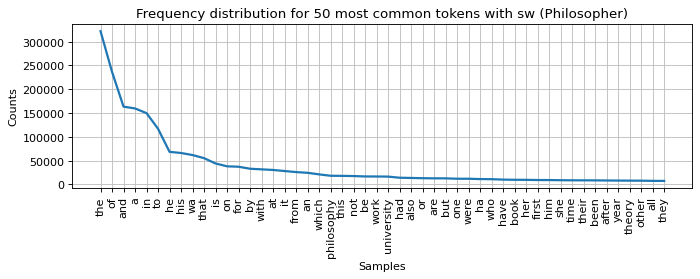

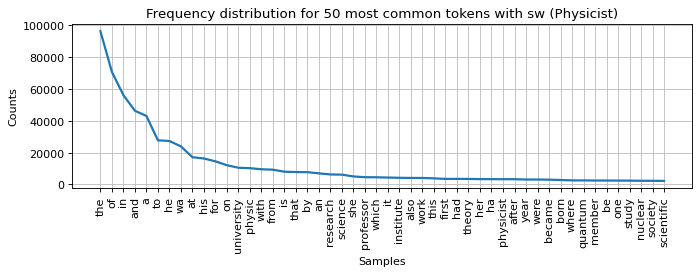

<Figure size 432x288 with 0 Axes>

In [32]:
fdist1 = FreqDist(top_words_phil_sw)
fdist2 = FreqDist(top_words_phys_sw)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens with sw (Philosopher)")
fdist1.plot(50)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens with sw (Physicist)")
fdist2.plot(50)

plt.tight_layout()
plt.show()

### Top 50 most common words in the whole corpus

In [33]:
tokens_sw = []
tokens_without_sw = []

for tokens_list in df["tokens_without_sw"]:  # get all the tokens without sw for Philosopher category
    tokens_without_sw += tokens_list
    
for tokens_list in df["tokens_sw"]:  # get all the tokens without sw for Philosopher category
    tokens_sw += tokens_list
    
# Get the 50 most common words for Philosopher
top_words = dict(collections.Counter(tokens_without_sw).most_common(50))

# Get the 50 most common words for Phiycisist
top_words_sw = dict(collections.Counter(tokens_sw).most_common(50))

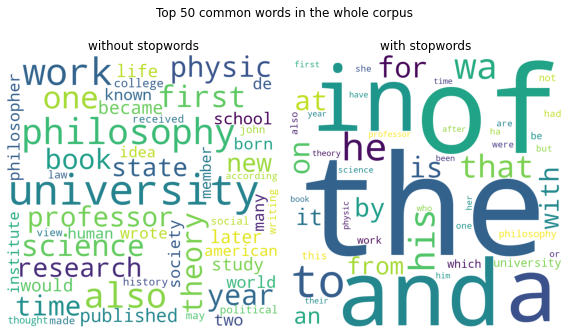

In [35]:
wordcloud_1 = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words)
wordcloud_2 = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(top_words_sw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Top 50 common words in the whole corpus")

ax1.imshow(wordcloud_1)
ax1.axis("off")
ax1.set_title("without stopwords")

ax2.imshow(wordcloud_2)
ax2.axis("off")
ax2.set_title("with stopwords")

plt.tight_layout()
plt.show()

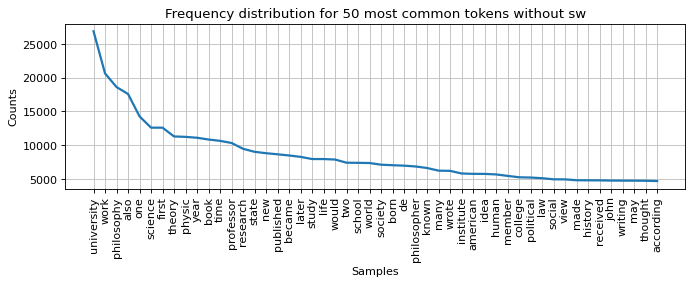

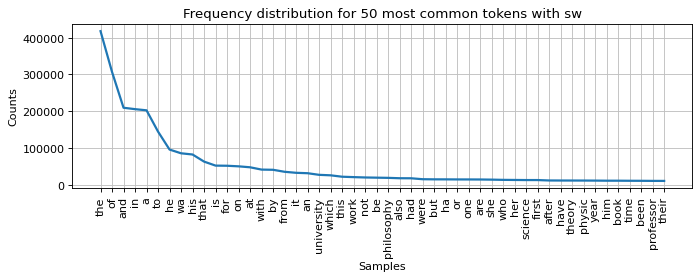

<Figure size 432x288 with 0 Axes>

In [36]:
fdist1 = FreqDist(tokens_without_sw)
fdist2 = FreqDist(tokens_sw)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens without sw")
fdist1.plot(50)

figure(figsize=(10, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.title("Frequency distribution for 50 most common tokens with sw")
fdist2.plot(50)

plt.tight_layout()
plt.show()

## Tokens statistics

### Calculate tokens statistics per each category

Here we will work with tokens without considering stop words since they don't contain any significant information that could be useful for analysis.

In [38]:
df["num_tokens"] = df["tokens_without_sw"].apply(lambda x: len(x))   
df["num_of_sentences"] = df["sentences_tokens"].apply(lambda x: len(x))  # number of sentences per text
df["num_tokens_per_sentence"] = df["num_tokens"] / df["num_of_sentences"]  # average number of tokens per sentence

In [39]:
def calculate_token_statistics(df):
    
    """
    Calculate the min, max, mean and median number of tokens for each category,
    min, max, average number of tokens per sentence for each category
    
    """
    df_stats = pd.DataFrame(columns=["category", "num_tokens_per_cat",  "min_num_tokens", "max_num_tokens", 
                                     "mean_num_tokens", "median_num_tokens", "min_num_tokens_per_sentence",
                                     "max_num_tokens_per_sentence", "mean_num_tokens_per_sentence"])
    
    df_stats["category"] = df["category"].unique()
    df_stats.set_index("category", inplace=True)
    
    df_stats["num_tokens_per_cat"] = df.groupby("category")["num_tokens"].sum() # total number of tokens per category
    df_stats["min_num_tokens"] = df.groupby("category")["num_tokens"].min() # min number of tokens per category
    df_stats["max_num_tokens"] = df.groupby("category")["num_tokens"].max() # max number of tokens per category
    df_stats["mean_num_tokens"] = df.groupby("category")["num_tokens"].mean() # average number of tokens per category
    df_stats["median_num_tokens"] = df.groupby("category")["num_tokens"].median() # median number of tokens per category

    df_stats["min_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].min() # min number of tokens per sentence per category
    df_stats["max_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].max() # max number of tokens per sentence per category
    df_stats["mean_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].mean() # average number of tokens per sentence per category
    df_stats["median_num_tokens_per_sentence"] = df.groupby("category")["num_tokens_per_sentence"].median() # median number of tokens per sentence per category
     
    return df_stats

In [41]:
stats = calculate_token_statistics(df)
stats

,num_tokens_per_cat,min_num_tokens,max_num_tokens,mean_num_tokens,median_num_tokens,min_num_tokens_per_sentence,max_num_tokens_per_sentence,mean_num_tokens_per_sentence,median_num_tokens_per_sentence
category,,,,,,,,,
Philosopher,2709868,7,10919,733.189394,317.0,4.186047,26.5,11.978490,12.000000
Physicist,790299,8,6156,286.029316,181.0,3.398936,38.0,11.429013,11.166667


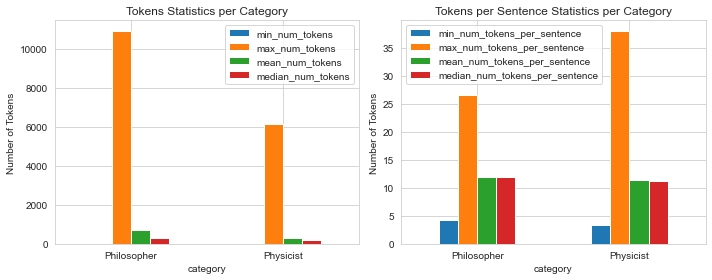

In [42]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

stats[["min_num_tokens", "max_num_tokens", "mean_num_tokens", "median_num_tokens"]].plot(
    kind="bar", ax=axes[0], title="Tokens Statistics per Category", rot=0)
axes[0].set_ylabel("Number of Tokens")
axes[0].legend(title=None)

stats[["min_num_tokens_per_sentence", "max_num_tokens_per_sentence", "mean_num_tokens_per_sentence",
       "median_num_tokens_per_sentence"]].plot(
    kind="bar", ax=axes[1], title="Tokens per Sentence Statistics per Category", rot=0)
axes[1].set_ylabel("Number of Tokens")
axes[1].legend(title=None)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

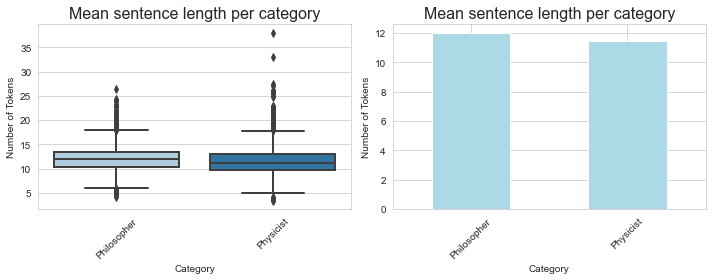

In [43]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

mean_data = df.groupby("category")["num_tokens_per_sentence"].mean()
sns.boxplot(x=df["category"], y=df["num_tokens_per_sentence"], palette="Paired", linewidth=2, ax=axes[0])
axes[0].set_title("Mean sentence length per category", fontsize=16)
axes[0].set_xlabel("Category", fontsize=10)
axes[0].set_ylabel("Number of Tokens", fontsize=10)
axes[0].tick_params(axis='x', labelrotation=45)

mean_data.plot(kind="bar", color="LightBlue", rot=0, ax=axes[1])
axes[1].set_title("Mean sentence length per category", fontsize=16)
axes[1].set_xlabel("Category", fontsize=10)
axes[1].set_ylabel("Number of Tokens", fontsize=10)
axes[1].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Sentence statistics

In [44]:
def calculate_sentence_stats(df):
    
    """
    calculate the min, max, mean and median 
    number of sentences for each category
    
    """
    df_stats = pd.DataFrame(columns=["category", "min_num_sentences", "max_num_sentences", 
                                  "avg_num_sentences", "median_num_sentences"])
    
    df_stats["category"] = df["category"].unique()
    df_stats.set_index("category", inplace=True)
    
    df_stats["min_num_sentences"] = df.groupby("category")["num_of_sentences"].min() # min number of sentences per category
    df_stats["max_num_sentences"] = df.groupby("category")["num_of_sentences"].max() # max number of sentences per category
    df_stats["avg_num_sentences"] = df.groupby("category")["num_of_sentences"].mean() # average number of sentences per category
    df_stats["median_num_sentences"] = df.groupby("category")["num_of_sentences"].median() # median number of sentences per category
    
    return df_stats

In [45]:
sent_stats = calculate_sentence_stats(df)
sent_stats

,min_num_sentences,max_num_sentences,avg_num_sentences,median_num_sentences
category,,,,
Philosopher,1,906,58.227002,27.0
Physicist,1,501,24.464712,17.0


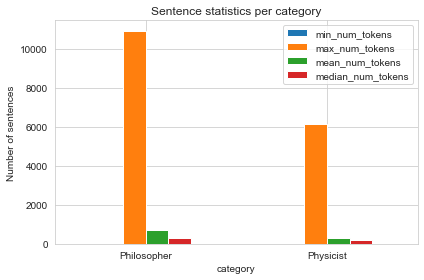

In [46]:
stats[["min_num_tokens", "max_num_tokens", "mean_num_tokens", "median_num_tokens"]].plot(
    kind="bar", title="Sentence statistics per category", rot=0)

plt.ylabel("Number of sentences")
plt.legend(title=None)

plt.tight_layout()
plt.show()

## POS tagging and Named entity recognition

### Vocabularies of POS

Spacy is used for getting POS information.

In [48]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
df["merged_tokens"] = df["tokens_without_sw"].apply(lambda x: " ".join(x)) #
df["POS_tags"] = df["merged_tokens"].apply(lambda x: nlp(x)) # POS tagging
df["POS_tags"] = df["POS_tags"].apply(lambda x: [token.pos_ for token in x]) # POS tagging
df["pos_token"] = df["POS_tags"].apply(lambda x: list(zip(x, df["tokens_without_sw"]))) # zip the tokens with their POS tags